# Milestone Project 1: Food Vision Big

## Checking GPU

* Google Colab offers free GPUs, however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed percision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-**gpus**)

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-8ff4aea8-5955-4f73-51f9-d8ca7d8d07c3)


## Getting helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-06 20:58:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-06 20:58:49 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Using TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide:
* https://www.tensorflow.org/datasets/overview

In [ ]:
# Get TnsorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes 5-6 mins in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete0CS288/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete0CS288/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 18
  Class name (str form): chicken_curry
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[170, 193, 165],
        [175, 198, 170],
        [187, 209, 186],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[169, 185, 159],
        [169, 184, 161],
        [171, 189, 167],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[166, 171, 151],
        [161, 166, 146],
        [158, 165, 147],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       ...,

       [[143, 131, 105],
        [143, 131, 105],
        [141, 132, 103],
        ...,
        [152, 131, 104],
        [153, 129, 103],
        [151, 127, 101]],

       [[139, 129, 102],
        [138, 128, 101],
        [137, 128,  99],
        ...,
        [150, 126, 100],
        [151, 125, 100],
        [152, 126,  99]],

       [[133, 123,  96],
        [134, 124,  97],
        [136, 127,  98],
        ...,
        [149, 125,  9

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=5>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

plotting an image from TensorFlow Datasets

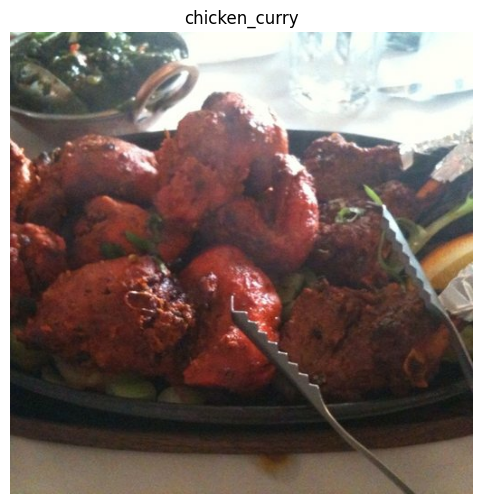

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Creating preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* in `uint8` datatype
* Comprised of all different sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` datatype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from `tf.keras.applications` we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to:
1. Reshape our images to all same size
2. Convert the datatype of our image tensors from `uint8` to `float32`

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' ➡ 'float32' and reshapes image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(images=image,
                          size=[img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (notrequired with EfficientNetBX models from tf.keras.aplications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a sample image and check the outputs
preprocessed_img = preprocess_img(image=image,
                                  label=label)[0]
print(f"Image before preprocessing:\n{image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
[[[170 193 165]
  [175 198 170]
  [187 209 186]
  ...
  [253 255 249]
  [253 255 249]
  [253 255 249]]

 [[169 185 159]
  [169 184 161]
  [171 189 167]
  ...
  [253 255 249]
  [253 255 249]
  [253 255 249]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[170.5051  188.59184 163.11736]
  [187.9898  206.82143 186.91837]
  [208.97958 225.69388 212.7653 ]
  ...
  [253.      255.      249.     ]
  [253.      255.      249.     ]
  [253.      255.      249.     ]]

 [[155.02551 149.47958 134.38776]
  [149.11224 149.47958 137.11734]
  [153.97449 162.87245 152.42857]
  ...
  [253.      255.      249.     ]
  [253.      255.      249.     ]
  [253.      255.      249.     ]]]..., 
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



## Batching & Preparing Datasets

We're now going to make our data input pipeline run really fast.

More resources on this:
* https://www.tensorflow.org/guide/data_performance

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=2000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [ ]:
# Create TensorBoard callback (Import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

## Setup Mixed Precision Training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision:
* https://www.tensorflow.org/guide/mixed_precision

Mixed Precision utilizes a combination of `float32` & `float16` datatypes to speed up model performance.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build Feature Extraction Model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers.experimental import preprocessing

>  🔑 **Note:** Use `SparseCategoricalCrossentropy` loss function when there are two or more label classes. We expect labels to be provided as integers. If you want to provide labels using one-hot representation, please use `CategoricalCrossentropy` loss.

In [ ]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = preprocessing.Rescaling(1./255) # if we are using a model other than EfficientNetBX , we might want to normalize our data first
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Check layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(f"Layer name: {layer.name}\nIs layer trainable: {layer.trainable}\nLayer datatype: {layer.dtype}\nLayer Dtype Policy: {layer.dtype_policy}")
  print("---------------------------------")

Layer name: input_layer
Is layer trainable: True
Layer datatype: float32
Layer Dtype Policy: <Policy "float32">
---------------------------------
Layer name: efficientnetb0
Is layer trainable: False
Layer datatype: float32
Layer Dtype Policy: <Policy "mixed_float16">
---------------------------------
Layer name: global_average_pooling2d
Is layer trainable: True
Layer datatype: float32
Layer Dtype Policy: <Policy "mixed_float16">
---------------------------------
Layer name: dense
Is layer trainable: True
Layer datatype: float32
Layer Dtype Policy: <Policy "mixed_float16">
---------------------------------
Layer name: softmax_float32
Is layer trainable: True
Layer datatype: float32
Layer Dtype Policy: <Policy "float32">
---------------------------------


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not (`True` ➡ trainable weights, `False` ➡ frozen weights)
* `layer.dtype`: the datatype a layer **stores** its variables in
* `layer.dtype_policy`: the datatype policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for i, layer in enumerate(model.layers[1].layers):
  print(str(i) + ")", layer.name, "➡",  layer.dtype_policy)

0) input_1 ➡ <Policy "float32">
1) rescaling ➡ <Policy "mixed_float16">
2) normalization ➡ <Policy "mixed_float16">
3) rescaling_1 ➡ <Policy "mixed_float16">
4) stem_conv_pad ➡ <Policy "mixed_float16">
5) stem_conv ➡ <Policy "mixed_float16">
6) stem_bn ➡ <Policy "mixed_float16">
7) stem_activation ➡ <Policy "mixed_float16">
8) block1a_dwconv ➡ <Policy "mixed_float16">
9) block1a_bn ➡ <Policy "mixed_float16">
10) block1a_activation ➡ <Policy "mixed_float16">
11) block1a_se_squeeze ➡ <Policy "mixed_float16">
12) block1a_se_reshape ➡ <Policy "mixed_float16">
13) block1a_se_reduce ➡ <Policy "mixed_float16">
14) block1a_se_expand ➡ <Policy "mixed_float16">
15) block1a_se_excite ➡ <Policy "mixed_float16">
16) block1a_project_conv ➡ <Policy "mixed_float16">
17) block1a_project_bn ➡ <Policy "mixed_float16">
18) block2a_expand_conv ➡ <Policy "mixed_float16">
19) block2a_expand_bn ➡ <Policy "mixed_float16">
20) block2a_expand_activation ➡ <Policy "mixed_float16">
21) block2a_dwconv_pad ➡ <Policy

## Fitting the Feature Extraction Model

If our goal is to fine-tune a pretrained model,  the general order of doing things is:
1. Build a feature extraction model (train a couple of output layers with base layers frozen)
2. Fine-tune some of the frozen layers

Basically..

```
Feature Extraction ➡ Fine-Tuning
```

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int( 0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230406-210937
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7182 - accuracy: 0.5825

2368/2368 [==============================] - 69s 22ms/step - loss: 1.7182 - accuracy: 0.5825 - val_loss: 1.1342 - val_accuracy: 0.6976
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1992 - accuracy: 0.6897

2368/2368 [==============================] - 51s 21ms/step - loss: 1.1992 - accuracy: 0.6897 - val_loss: 1.0316 - val_accuracy: 0.7206
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.7227

2368/2368 [==============================] - 51s 21ms/step - loss: 1.0542 - accuracy: 0.7227 - val_loss: 0.9923 - val_accuracy: 0.7317


In [ ]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 13s 16ms/step - loss: 0.9942 - accuracy: 0.7310


[0.9942229986190796, 0.7309703230857849]

### Fine-tuning

In [ ]:
# Unfreeze base_model
base_model.trainable = True

# Freeze layers except last 10 layers
for layer in base_model.layers[:-110]:
  layer.trainable = False

In [ ]:
# Recompile
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
softmax_float32 True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model.layers[1].layers):
  print(str(i) + ")", layer.name, "-", layer.trainable)

0) input_1 - False
1) rescaling - False
2) normalization - False
3) rescaling_1 - False
4) stem_conv_pad - False
5) stem_conv - False
6) stem_bn - False
7) stem_activation - False
8) block1a_dwconv - False
9) block1a_bn - False
10) block1a_activation - False
11) block1a_se_squeeze - False
12) block1a_se_reshape - False
13) block1a_se_reduce - False
14) block1a_se_expand - False
15) block1a_se_excite - False
16) block1a_project_conv - False
17) block1a_project_bn - False
18) block2a_expand_conv - False
19) block2a_expand_bn - False
20) block2a_expand_activation - False
21) block2a_dwconv_pad - False
22) block2a_dwconv - False
23) block2a_bn - False
24) block2a_activation - False
25) block2a_se_squeeze - False
26) block2a_se_reshape - False
27) block2a_se_reduce - False
28) block2a_se_expand - False
29) block2a_se_excite - False
30) block2a_project_conv - False
31) block2a_project_bn - False
32) block2b_expand_conv - False
33) block2b_expand_bn - False
34) block2b_expand_activation - Fal

In [ ]:
# fine-tune for another 3 epochs
fine_tune_epochs = 6

# Refit model
history_101_food_classes_fine_tune = model.fit(train_data,
                                               epochs=fine_tune_epochs,
                                               steps_per_epoch=(len(train_data)),
                                               validation_data=test_data,
                                               validation_steps=int( 0.15 * len(test_data)),
                                               initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                      experiment_name="efficientnetb0_101_classes_all_data_fine_tune"),
                                                          model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune/20230406-211242


Epoch 3/6
2368/2368 [==============================] - ETA: 0s - loss: 0.8598 - accuracy: 0.7675

2368/2368 [==============================] - 116s 38ms/step - loss: 0.8598 - accuracy: 0.7675 - val_loss: 0.7872 - val_accuracy: 0.7762
Epoch 4/6
2368/2368 [==============================] - ETA: 0s - loss: 0.5344 - accuracy: 0.8534

2368/2368 [==============================] - 89s 37ms/step - loss: 0.5344 - accuracy: 0.8534 - val_loss: 0.7926 - val_accuracy: 0.7905
Epoch 5/6
2367/2368 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.9174

2368/2368 [==============================] - 87s 36ms/step - loss: 0.2956 - accuracy: 0.9175 - val_loss: 0.9086 - val_accuracy: 0.7733
Epoch 6/6
2367/2368 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9589

2368/2368 [==============================] - 90s 37ms/step - loss: 0.1450 - accuracy: 0.9589 - val_loss: 0.9526 - val_accuracy: 0.7799


In [ ]:
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 12s 15ms/step - loss: 0.9927 - accuracy: 0.7770


[0.992729127407074, 0.7769901156425476]

In [ ]:
feature_extraction_results

[0.9942229986190796, 0.7309703230857849]

## Evaluating our Fine-tuned Model Predictions

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 13s 14ms/step


In [ ]:
# How many batches are there?
len(test_data)

790

In [ ]:
# How many predictions are there?
len(pred_probs)

25250

In [ ]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 prediction probability arrays look like
pred_probs[:10]

array([[3.4875742e-07, 1.1083488e-06, 2.6699941e-04, ..., 4.5747019e-08,
        3.1084414e-06, 6.5529584e-08],
       [5.1082602e-12, 2.7656593e-14, 3.1423744e-09, ..., 1.3381844e-10,
        1.0043630e-09, 8.3390055e-13],
       [3.8796300e-11, 1.9124975e-13, 4.6797271e-11, ..., 1.2163834e-09,
        1.8800150e-10, 9.1762637e-14],
       ...,
       [5.6966156e-09, 9.5981878e-01, 3.1196245e-13, ..., 9.4459152e-10,
        4.8042577e-12, 1.4040100e-10],
       [7.3597866e-09, 3.1294607e-07, 1.2343889e-11, ..., 7.2675300e-15,
        1.4453208e-14, 4.8470031e-07],
       [5.1755280e-09, 7.8751639e-10, 7.4516036e-14, ..., 3.5549615e-13,
        6.4005515e-12, 1.1754709e-08]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
pred_probs[0], len(pred_probs)

(array([3.48757425e-07, 1.10834878e-06, 2.66999414e-04, 1.65783698e-04,
        7.78183065e-08, 3.17069615e-04, 9.00812225e-09, 1.17134880e-02,
        1.69358700e-05, 3.93770788e-05, 3.83035086e-07, 8.72304589e-02,
        2.60658659e-08, 1.06365000e-07, 2.44497860e-05, 2.68528365e-05,
        5.70529153e-07, 3.19365689e-08, 1.28879782e-03, 9.52015616e-05,
        5.88639637e-07, 6.97558704e-08, 1.72647461e-07, 1.02659936e-09,
        1.40698801e-04, 1.54760158e-07, 1.96046926e-06, 3.56278136e-08,
        8.41416394e-08, 5.63713920e-09, 9.68464420e-08, 6.45136424e-08,
        2.20089941e-03, 2.04285589e-05, 2.85846945e-05, 9.37256118e-05,
        4.03716029e-08, 5.04549826e-06, 3.32786669e-07, 5.46696574e-05,
        1.70687017e-05, 2.22617800e-05, 4.37439837e-07, 1.02351326e-03,
        1.71766970e-02, 7.63359458e-06, 2.21683734e-07, 5.84407663e-03,
        3.63413596e-06, 1.22941237e-05, 1.18729624e-03, 1.10435743e-04,
        4.49700383e-05, 1.03092496e-07, 5.25752985e-05, 3.757387

In [ ]:
# We get one prediction probability per class (inour case ther's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0:\n {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0:
 101
What prediction probability sample 0 looks like:
 [3.48757425e-07 1.10834878e-06 2.66999414e-04 1.65783698e-04
 7.78183065e-08 3.17069615e-04 9.00812225e-09 1.17134880e-02
 1.69358700e-05 3.93770788e-05 3.83035086e-07 8.72304589e-02
 2.60658659e-08 1.06365000e-07 2.44497860e-05 2.68528365e-05
 5.70529153e-07 3.19365689e-08 1.28879782e-03 9.52015616e-05
 5.88639637e-07 6.97558704e-08 1.72647461e-07 1.02659936e-09
 1.40698801e-04 1.54760158e-07 1.96046926e-06 3.56278136e-08
 8.41416394e-08 5.63713920e-09 9.68464420e-08 6.45136424e-08
 2.20089941e-03 2.04285589e-05 2.85846945e-05 9.37256118e-05
 4.03716029e-08 5.04549826e-06 3.32786669e-07 5.46696574e-05
 1.70687017e-05 2.22617800e-05 4.37439837e-07 1.02351326e-03
 1.71766970e-02 7.63359458e-06 2.21683734e-07 5.84407663e-03
 3.63413596e-06 1.22941237e-05 1.18729624e-03 1.10435743e-04
 4.49700383e-05 1.03092496e-07 5.25752985e-05 3.75738709e-05
 6.41846191e-03 1.19409517e-04 2.63255941e

In [ ]:
class_names[70]

'pad_thai'

In [ ]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look
pred_classes[:10]

array([70, 60, 29, 80, 32, 78, 19,  1, 40, 40])

In [ ]:
# How many pred classes do we have
len(pred_classes)

25250

In [ ]:
for images, labels in test_data.take(5):
  print(labels)

tf.Tensor(
[  1  75  61  74  54  76  34  90  15   4  15  19  49 100  93  62  90  33
   9  12  78  77  96   6  48   9  38  74  52   7  26  90], shape=(32,), dtype=int64)
tf.Tensor(
[ 42  57  46  69 100  38  10  86  16  83  63  27  36  66  76   9   3  73
  22  59  12  39  90   6  23  44  39   6  77  56  96  42], shape=(32,), dtype=int64)
tf.Tensor(
[15 49 12  7 33 52 69 54 88 50 53  3 38  6 84 70 83 16 60 32 36 94 48  0
 65 29 56 37 87 65 64 26], shape=(32,), dtype=int64)
tf.Tensor(
[ 57  48  79  44  81  43  27  47  46  22  99  70 100  90  21  59  28  12
   4  66  55  32  19  42  63  91  16  97  79  41  95   4], shape=(32,), dtype=int64)
tf.Tensor(
[ 78 100  79   4  37  14  42  69  30  44  17  44  22  77  17   6  93  83
  98  40  60  13  36  92  21  25  29  81  66  81   1  92], shape=(32,), dtype=int64)


In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data.take(len(pred_probs)):
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, 0,... 0, 0], we want the index value where the "1" occurs

y_labels[:10] # Look at the first 10

[1, 14, 12, 21, 17, 6, 19, 20, 6, 17]

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, 0,... 0, 0], we want the index value where the "1" occurs

y_labels[:10] # Look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

In [ ]:
print(tf.constant(y_labels).shape)
print(pred_classes.shape)

(25250,)
(25250,)


In [ ]:
# Let's try Scikit-learn's accuracy score function and see what it come up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

0.0072871287128712875

In [ ]:
fine_tune_results[1]

[0.992729127407074, 0.7769901156425476]

In [ ]:
sklearn_accuracy

0.0072871287128712875

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(fine_tune_results[1], sklearn_accuracy)

False

## Let's Get Visual: Making a Confusion Matrix

In [ ]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# We need to make some changes to our make_confusion_matrix function to ensure the x-labels display vertically

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

<ipython-input-61-93e73b7b9dc4>:35: RuntimeWarning: invalid value encountered in true_divide
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it


### Time for Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels,
                                                   y_pred=pred_classes,
                                                   output_dict=True)
classification_report_dict

Let's plot all of our classes F1-scores...

In [ ]:
classification_report_dict['99']['f1-score']

In [ ]:
# Create empty dictionary
class_f1_scores= {}
# Loop through classification report dictionary items
for key, value in classification_report_dict.items():
  if key == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(key)]] = value["f1-score"]

class_f1_scores

In [ ]:
# Extra Step: Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-score":list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

f1_scores[:10]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Class (predicted by Food Vision Mini)")
ax.invert_yaxis(); # revert the order of our plot

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it'll need to:
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values between 0 & 1)
    return img/225.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

Now we've got a function to load and prepare target images,
let's now write some code to visualize images, their target label and our model's prediction.

Specifically, we'll write some code to:
1. Load a few random imagesfrom the test dataset
2. make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth labelv

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(30,14))
num_img = 16
rows = 4
for i in range(num_img):
  # Choose random images from random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  print(filepath)

  # Load the image and make predictions
  img = load_and_prep_image(filename=filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it with class_name list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(rows, int(num_img/rows), i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, Pred: {pred_class}, Prob: {pred_prob.max()*100:.2f}%", c=title_color)
  plt.axis(False);